In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import plotly.graph_objects as go
import plotly.express as px
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import callbacks
import seaborn as sns
from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.backend as K
import tensorflow_hub as hub
import matplotlib.image as img

In [ ]:
train_dir= '/content/drive/MyDrive/SN BOSE/summer project/archive (5)/Training'
test_dir = '/content/drive/MyDrive/SN BOSE/summer project/archive (5)/Testing'

In [ ]:
img_height = 224
img_width = 224
batch_size = 32

train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode= 'int'
)

#Define Classes Names
class_names= train_data.class_names

Found 5712 files belonging to 4 classes.


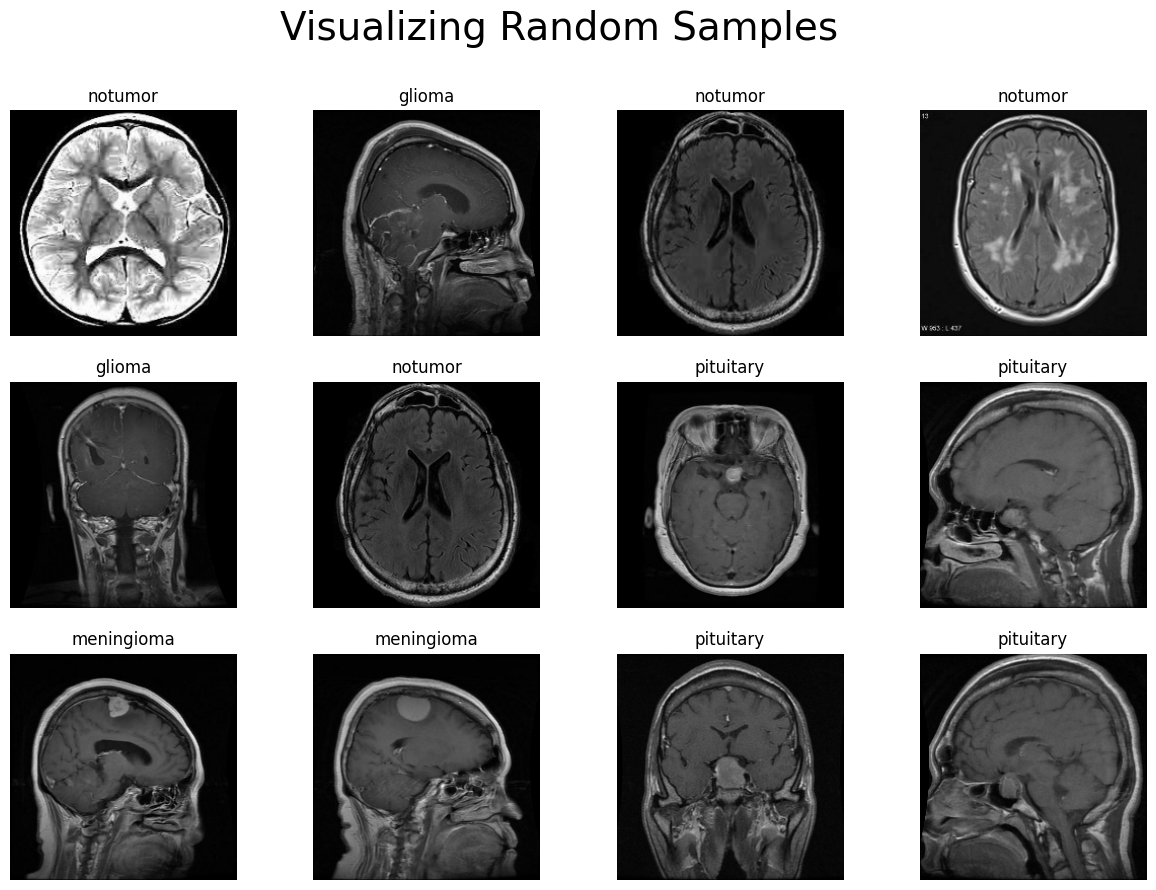

In [ ]:
fig = plt.figure(figsize=(15, 10))
fig.suptitle("Visualizing Random Samples" , fontsize = 28)
for images, labels in train_data.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
def each_class_samples(train_data):

    meningioma = 0
    notumor = 0
    glioma = 0
    pituitary = 0
    #-->Looping over the train_data
    for images, labels in train_data:
        for i in range(len(images)):
            if class_names[labels[i]] == 'meningioma':
                meningioma +=1
            elif class_names[labels[i]] == 'notumor':
                notumor +=1
            elif class_names[labels[i]] == 'glioma':
                glioma +=1
            elif class_names[labels[i]] == 'pituitary':
                pituitary +=1

    print("meningioma : " + str(meningioma))
    print("glioma : " + str(glioma))
    print("notumor : " + str(notumor))
    print("pituitary : " + str(pituitary))

    return [meningioma , glioma , notumor , pituitary]

meningioma, glioma, notumor,pituitary= each_class_samples(train_data)

meningioma : 1339
glioma : 1321
notumor : 1595
pituitary : 1457


In [ ]:
fig = go.Figure(go.Bar(
            x= [meningioma,glioma,pituitary,notumor],
            y= ['meningioma','glioma','pituitary','notumor'],
            orientation='h'))

fig.update_layout(title='Brain Tumor Distribution',font_size=15,title_x=0.45)


fig.show()

In [ ]:
img_size = (224 , 224)
batch_size = 32


#Defining train_data again
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir ,
    image_size = img_size ,
    label_mode = "categorical" ,
    batch_size = batch_size ,)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir ,
    image_size = img_size ,
    label_mode = "categorical" ,
    batch_size = batch_size ,)


#Defining CallBack list

callback_list=[
    callbacks.EarlyStopping(monitor="val_accuracy",patience=10,restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.8,monitor="val_accuracy",patience=3)
]

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape = (224 , 224 , 3) , name = "Input_layer")

x = base_model(inputs)

x = Conv2D(32 , 3 , padding = 'same' , activation = "relu" , name = "Top_Conv_Layer")(x)

x = tf.keras.layers.GlobalAveragePooling2D(name = "Global_avg_Pooling_2D")(x)

outputs = tf.keras.layers.Dense(4 ,
                                activation = "softmax" ,
                                name = "Output_layer")(x)
Model_1 = tf.keras.Model(inputs , outputs)
Model_1.compile(
    loss = tf.keras.losses.categorical_crossentropy ,
    optimizer = tf.keras.optimizers.Adam() ,
    metrics = ['accuracy']
)

Model_1_History = Model_1.fit(train_data , validation_data = test_data , epochs = 5  , verbose = 1 , callbacks = callback_list)

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/5
179/179 [==============================] - 261s 1s/step - loss: 0.3516 - accuracy: 0.8669 - val_loss: 0.2832 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 2/5
179/179 [==============================] - 33s 178ms/step - loss: 0.1880 - accuracy: 0.9277 - val_loss: 0.2126 - val_accuracy: 0.9176 - lr: 0.0010
Epoch 3/5
179/179 [==============================] - 28s 151ms/step - loss: 0.1320 - accuracy: 0.9513 - val_loss: 0.1486 - val_accuracy: 0.9436 - lr: 0.0010
Epoch 4/5
179/179 [==============================] - 29s 156ms/step - loss: 0.1034 - accuracy: 0.9617 - val_loss: 0.1508 - val_accuracy: 0.9466 - lr: 0.0010
Epoch 5/5
179/179 [==============================] - 28s 151ms/step - loss: 0.0860 - accuracy: 0.9687 - val_loss: 0.0991 - val_accuracy: 0.9634 - lr: 0.0010


In [ ]:
base_model.trainable = True

#Freezing all the layers except last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False


#ReCompile the model
Model_1.compile(loss = "categorical_crossentropy" ,
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001),
                metrics = ["accuracy"]
               )


#FineTune for 10 epochs
initial_epoch = 5
Fine_Tune_epoch = initial_epoch + 10

#Refit the model
Stage_2_history = Model_1.fit(train_data ,
                              epochs = Fine_Tune_epoch ,
                              validation_data = test_data ,
                              validation_steps = len(test_data) ,
                              initial_epoch = initial_epoch-1 )

Epoch 5/15
179/179 [==============================] - 39s 162ms/step - loss: 0.0923 - accuracy: 0.9699 - val_loss: 0.0825 - val_accuracy: 0.9710
Epoch 6/15
179/179 [==============================] - 28s 154ms/step - loss: 0.0511 - accuracy: 0.9828 - val_loss: 0.0728 - val_accuracy: 0.9741
Epoch 7/15
179/179 [==============================] - 32s 172ms/step - loss: 0.0386 - accuracy: 0.9876 - val_loss: 0.0749 - val_accuracy: 0.9680
Epoch 8/15
179/179 [==============================] - 30s 162ms/step - loss: 0.0325 - accuracy: 0.9904 - val_loss: 0.0650 - val_accuracy: 0.9771
Epoch 9/15
179/179 [==============================] - 30s 163ms/step - loss: 0.0248 - accuracy: 0.9932 - val_loss: 0.0574 - val_accuracy: 0.9779
Epoch 10/15
179/179 [==============================] - 35s 193ms/step - loss: 0.0223 - accuracy: 0.9940 - val_loss: 0.0615 - val_accuracy: 0.9794
Epoch 11/15
179/179 [==============================] - 29s 156ms/step - loss: 0.0196 - accuracy: 0.9944 - val_loss: 0.0698 - val_

In [ ]:
Model_1.compile(loss = "categorical_crossentropy" ,
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001), #--< lower the LR by 10x
                metrics = ["accuracy"]
                )

In [ ]:
initial_epoch = 15

Fine_Tune_epoch = initial_epoch + 2

Stage_2_1_History = Model_1.fit(train_data , epochs = Fine_Tune_epoch , validation_data = test_data ,
                                      validation_steps = len(test_data) , initial_epoch = initial_epoch #--> Start from previous last epoch
                                    )

Epoch 16/17
179/179 [==============================] - 43s 187ms/step - loss: 0.0117 - accuracy: 0.9968 - val_loss: 0.0449 - val_accuracy: 0.9832
Epoch 17/17
179/179 [==============================] - 30s 160ms/step - loss: 0.0091 - accuracy: 0.9972 - val_loss: 0.0420 - val_accuracy: 0.9847


In [ ]:
last_conv_layer_name = "Top_Conv_Layer"

def get_img_array(img_path, size = (224 , 224)):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array



def make_gradcam_heatmap(img_array, model = Model_1 , last_conv_layer_name = last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4 , view = False):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    if view :
        display(Image(cam_path))

def decode_predictions(preds):
    classes = ['Glioma' , 'meningioma' , 'No Tumor' , 'Pituitary']
    prediction = classes[np.argmax(preds)]
    return prediction

def make_prediction (img_path , model = Model_1 , last_conv_layer_name = last_conv_layer_name , campath = "cam.jpeg" , view = False):
    img = get_img_array(img_path = img_path)
    img_array = get_img_array(img_path, size=(224 , 224))
    preds = Model_1.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap , cam_path=campath , view = view)
    return [campath , decode_predictions(preds)]


1/1 [==============================] - 6s 6s/step
meningioma


(-0.5, 527.5, 580.5, -0.5)

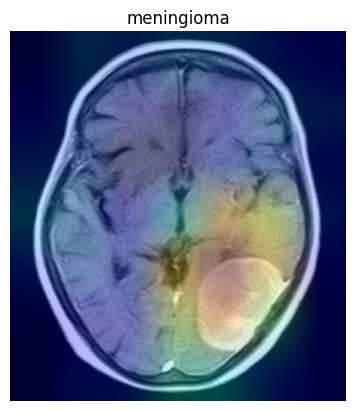

In [ ]:
campath , prediction = make_prediction("/content/drive/MyDrive/SN BOSE/summer project/archive (5)/Testing/meningioma/Te-meTr_0004.jpg" , campath="123.jpeg" , view = False)
print(prediction)
test_img = img.imread(campath)
plt.imshow(test_img)
plt.title(prediction)
plt.axis("off")

1/1 [==============================] - 0s 24ms/step


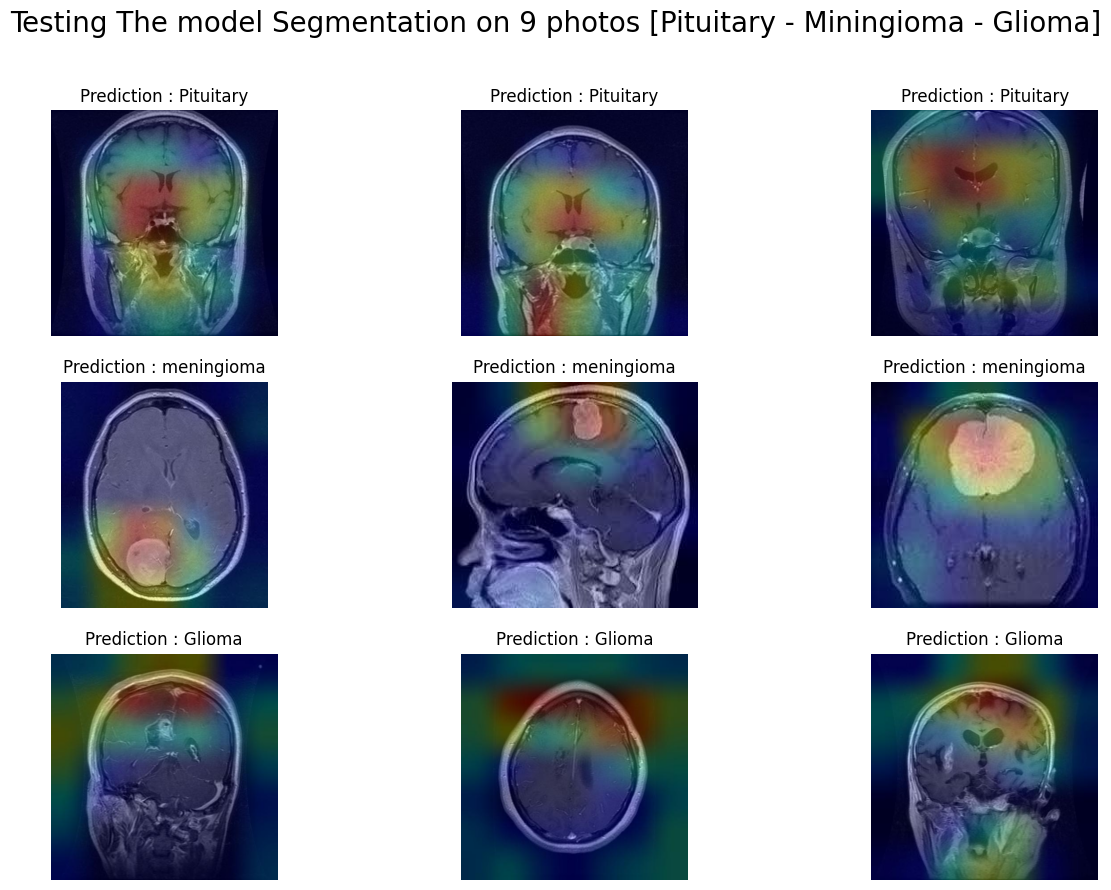

In [ ]:
path_array = [
  '/content/drive/MyDrive/SN BOSE/summer project/archive (5)/Testing/pituitary/Te-pi_0070.jpg' ,
  '/content/drive/MyDrive/SN BOSE/summer project/archive (5)/Testing/pituitary/Te-pi_0050.jpg' ,
  '/content/drive/MyDrive/SN BOSE/summer project/archive (5)/Testing/pituitary/Te-pi_0051.jpg' ,
  '/content/drive/MyDrive/SN BOSE/summer project/archive (5)/Testing/meningioma/Te-me_0010.jpg' ,
  '/content/drive/MyDrive/SN BOSE/summer project/archive (5)/Testing/meningioma/Te-me_0056.jpg' ,
  '/content/drive/MyDrive/SN BOSE/summer project/archive (5)/Testing/meningioma/Te-me_0095.jpg' ,
  '/content/drive/MyDrive/SN BOSE/summer project/archive (5)/Testing/glioma/Te-gl_0059.jpg' ,
  '/content/drive/MyDrive/SN BOSE/summer project/archive (5)/Testing/glioma/Te-gl_0118.jpg' ,
  '/content/drive/MyDrive/SN BOSE/summer project/archive (5)/Testing/glioma/Te-gl_0045.jpg' ,

]

fig = plt.figure(figsize=(15, 10))
fig.suptitle("Testing The model Segmentation on 9 photos [Pituitary - Miningioma - Glioma]" , fontsize = 20)
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        campath , prediction = make_prediction(path_array[i] , campath=f"{i}.jpeg")
        test_img = img.imread(campath)
        plt.imshow(test_img)
        plt.title("Prediction : " + prediction)
        plt.axis("off")

In [ ]:
import joblib

In [ ]:
joblib.dump(Model_1,'model_saved')

['model_saved']

In [ ]:
loaded_model= joblib.load('/content/model_saved')

1/1 [==============================] - 0s 24ms/step


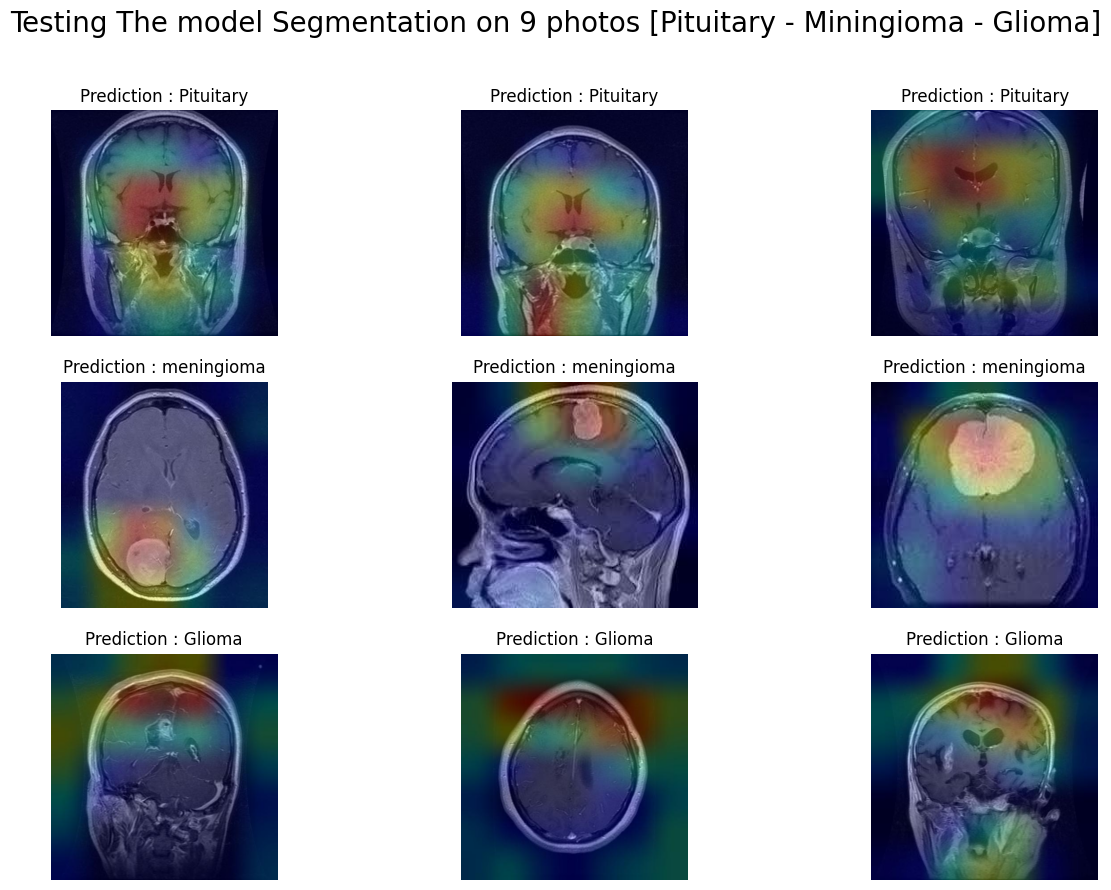

In [ ]:
path_array = [
  '/content/drive/MyDrive/SN BOSE/summer project/archive (5)/Testing/pituitary/Te-pi_0070.jpg' ,
  '/content/drive/MyDrive/SN BOSE/summer project/archive (5)/Testing/pituitary/Te-pi_0050.jpg' ,
  '/content/drive/MyDrive/SN BOSE/summer project/archive (5)/Testing/pituitary/Te-pi_0051.jpg' ,
  '/content/drive/MyDrive/SN BOSE/summer project/archive (5)/Testing/meningioma/Te-me_0010.jpg' ,
  '/content/drive/MyDrive/SN BOSE/summer project/archive (5)/Testing/meningioma/Te-me_0056.jpg' ,
  '/content/drive/MyDrive/SN BOSE/summer project/archive (5)/Testing/meningioma/Te-me_0095.jpg' ,
  '/content/drive/MyDrive/SN BOSE/summer project/archive (5)/Testing/glioma/Te-gl_0059.jpg' ,
  '/content/drive/MyDrive/SN BOSE/summer project/archive (5)/Testing/glioma/Te-gl_0118.jpg' ,
  '/content/drive/MyDrive/SN BOSE/summer project/archive (5)/Testing/glioma/Te-gl_0045.jpg' ,

]

fig = plt.figure(figsize=(15, 10))
fig.suptitle("Testing The model Segmentation on 9 photos [Pituitary - Miningioma - Glioma]" , fontsize = 20)
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        campath , prediction = make_prediction(path_array[i] , campath=f"{i}.jpeg")
        test_img = img.imread(campath)
        plt.imshow(test_img)
        plt.title("Prediction : " + prediction)
        plt.axis("off")

In [ ]:
loaded_model.predict(get_img_array("/content/drive/MyDrive/SN BOSE/summer project/archive (5)/Testing/glioma/Te-gl_0045.jpg"))

1/1 [==============================] - 0s 27ms/step


array([[9.9271226e-01, 7.2860327e-03, 1.4475480e-06, 3.1245324e-07]],
      dtype=float32)

In [ ]:
from tensorflow.keras.models import load_model
Model_1.save('/content/drive/MyDrive/SN BOSE/summer project/saved_model/model.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [ ]:
Model_1.save('/content/drive/MyDrive/SN BOSE/summer project/saved_model_2/modell.h5')